# This is a Jupyter notebook for David Dobrinskiy's HSE Thesis
## How Venture Capital Affects Startups' Success


In [1]:
# You should be running python3

import sys
print(sys.version)

3.5.2+ (default, Sep 22 2016, 12:18:14) 
[GCC 6.2.0 20160927]


In [2]:
import pandas as pd  # http://pandas.pydata.org/
import numpy as np   # http://numpy.org/

import statsmodels.api as sm  # http://statsmodels.sourceforge.net/stable/
import statsmodels.formula.api as smf

print("Pandas Version: {}".format(pd.__version__))  # pandas version

Pandas Version: 0.19.0


### Let us look at the dynamics of total US VC investment

In [3]:
# file from http://www.pwcmoneytree.com/Reports/Homepage%20NationalAgg.xlsx as of October 10, 2016: 15:00
# contains quarterly data on total num and $ of VC deals in USA from 1995
file = 'data/HomepageNationalAgg.xlsx'
sheet = "Total US by Qtr & Year"

#import XLSX
f1 = pd.read_excel(file, sheet, header=11)

In [4]:
vc_total = f1 # use vc_total to play around with data without downloading it again

# NOTE: vc_total is a pandas dataframe
# go to http://pandas.pydata.org for reference
type(vc_total)

pandas.core.frame.DataFrame

In [5]:
# vc_total

In [6]:
vc_total = vc_total.drop(vc_total.index[ [6, 7]]) # delete last 2 rows
# vc_total = vc_total.drop(vc_total.columns[-2:], axis=1) # delete last 2 columns (for 2016q1)
vc_total

,Quarter,1995,Unnamed: 2,1996,Unnamed: 4,1997,Unnamed: 6,1998,Unnamed: 8,1999,...,2012,Unnamed: 36,2013,Unnamed: 38,2014,Unnamed: 40,2015,Unnamed: 42,2016,Unnamed: 44
0,NaN,# of Deals,Amount Invested,# of Deals,Amount Invested,# of Deals,Amount Invested,# of Deals,Amount Invested,# of Deals,...,Deals,Amount Invested,Deals,Amount Invested,Deals,Amount Invested,Deals,Amount Invested,Deals,Amount Invested
1,1,503,1690040500,585,2437964900,773,3104430200,871,4199545200,936,...,904,6329210900,956,6155589700,1062,10815557600,1091,13623792600,1021,12641621200
2,2,466,2546374500,671,3017298000,778,3691566400,912,5784400500,1330,...,1016,7556279300,1055,7323978700,1205,14059200200,1234,17435147700,999,15570439500
3,3,434,1709754500,604,2606841300,762,3775959100,931,5412295700,1448,...,988,6760302700,1108,8111446600,1088,10533959200,1189,16713968800,891,10626879300
4,4,494,2070353900,775,3223318800,919,4499598900,1030,6165090000,1892,...,1097,7079726500,1188,8703206900,1143,15742056800,1047,12335136900,NaN,NaN
5,Grand Total,1897,8016523400,2635,11285423000,3232,15071554600,3744,21561331400,5606,...,4005,27725519400,4307,30294221900,4498,51150773800,4561,60108046000,2911,38838940000


In [7]:
names = ['Quarter']  # create list for names
y = 1995             # first year in our data is 1995
while y <= 2016:     # columns alternate b/w Deal Num and Investment $ for the same year, thus append Y twice
    names.append(y)
    names.append(y)
    y += 1

print(names[:9])
print('...')
print(names[-10:])

['Quarter', 1995, 1995, 1996, 1996, 1997, 1997, 1998, 1998]
...
[2012, 2012, 2013, 2013, 2014, 2014, 2015, 2015, 2016, 2016]


In [8]:
vc_total.columns = names
vc_total

,Quarter,1995,1995,1996,1996,1997,1997,1998,1998,1999,...,2012,2012,2013,2013,2014,2014,2015,2015,2016,2016
0,NaN,# of Deals,Amount Invested,# of Deals,Amount Invested,# of Deals,Amount Invested,# of Deals,Amount Invested,# of Deals,...,Deals,Amount Invested,Deals,Amount Invested,Deals,Amount Invested,Deals,Amount Invested,Deals,Amount Invested
1,1,503,1690040500,585,2437964900,773,3104430200,871,4199545200,936,...,904,6329210900,956,6155589700,1062,10815557600,1091,13623792600,1021,12641621200
2,2,466,2546374500,671,3017298000,778,3691566400,912,5784400500,1330,...,1016,7556279300,1055,7323978700,1205,14059200200,1234,17435147700,999,15570439500
3,3,434,1709754500,604,2606841300,762,3775959100,931,5412295700,1448,...,988,6760302700,1108,8111446600,1088,10533959200,1189,16713968800,891,10626879300
4,4,494,2070353900,775,3223318800,919,4499598900,1030,6165090000,1892,...,1097,7079726500,1188,8703206900,1143,15742056800,1047,12335136900,NaN,NaN
5,Grand Total,1897,8016523400,2635,11285423000,3232,15071554600,3744,21561331400,5606,...,4005,27725519400,4307,30294221900,4498,51150773800,4561,60108046000,2911,38838940000


In [9]:
vc_total = vc_total.transpose()
vc_total.tail(6)

,0,1,2,3,4,5
2014,Deals,1062,1205,1088,1143,4498
2014,Amount Invested,10815557600,14059200200,10533959200,15742056800,51150773800
2015,Deals,1091,1234,1189,1047,4561
2015,Amount Invested,13623792600,17435147700,16713968800,12335136900,60108046000
2016,Deals,1021,999,891,NaN,2911
2016,Amount Invested,12641621200,15570439500,10626879300,NaN,38838940000


Note that 2 consecutive rows are Deals and Amount Invested for the same year, thus step by 2 to access only investment or only deals

In [10]:
# Amount Invested
invested = vc_total.iloc[::2,1:5]
invested.tail(6)

,1,2,3,4
2011,6530429100,8259744500,7609822800,7526605900
2012,6329210900,7556279300,6760302700,7079726500
2013,6155589700,7323978700,8111446600,8703206900
2014,10815557600,14059200200,10533959200,15742056800
2015,13623792600,17435147700,16713968800,12335136900
2016,12641621200,15570439500,10626879300,NaN


In [11]:
invested_quarterly = []
for i in range(1,len(invested)):  # len(invested)
    # print(invested.iloc[i])
    #print(invested.iloc[i].name)
    for j in invested.iloc[i].index:
        if invested.iloc[i,j-1] > 0:  # do not append NAN values (last 3 quarters of 2016)
            invested_quarterly.append(invested.iloc[i,j-1]) 

invested_quarterly[-5:]

[16713968800, 12335136900, 12641621200, 15570439500, 10626879300]

In [12]:
# Deals
deals = vc_total.iloc[1::2,1:5]
deals.head()

,1,2,3,4
1995,503,466,434,494
1996,585,671,604,775
1997,773,778,762,919
1998,871,912,931,1030
1999,936,1330,1448,1892


In [13]:
deals_quarterly = []
for i in range(0,len(deals)):  # len(invested)
    for j in deals.iloc[i].index:
        if deals.iloc[i,j-1] > 0:  # do not append NAN values (last 3 quarters of 2016)
            deals_quarterly.append(deals.iloc[i,j-1])

deals_quarterly[-5:]

[1189, 1047, 1021, 999, 891]

In [14]:
# check length equality
print(len(invested_quarterly))
print(len(deals_quarterly))

87
87


In [15]:
# create time series index from 1995q1 to 2016q1 matching our data observations
quarters = pd.period_range('1995Q1', '2016Q3', freq='Q-NOV')

# create a dataframe for deals & investments
d = {'Invested' : pd.Series(invested_quarterly, index=quarters),
        'Deals' : pd.Series(deals_quarterly,    index=quarters)}

result = pd.DataFrame(d)
result.tail()

,Deals,Invested
2015Q3,1189,16713968800
2015Q4,1047,12335136900
2016Q1,1021,12641621200
2016Q2,999,15570439500
2016Q3,891,10626879300


In [16]:
result['Invested'] = result['Invested'] / 10**9  # convert invested to BILLIONS
result.columns = ["Deals", "Invested ($ Bill)"]
print(result.head())
print(result.tail())

        Deals  Invested ($ Bill)
1995Q1    503           1.690041
1995Q2    466           2.546375
1995Q3    434           1.709755
1995Q4    494           2.070354
1996Q1    585           2.437965
        Deals  Invested ($ Bill)
2015Q3   1189          16.713969
2015Q4   1047          12.335137
2016Q1   1021          12.641621
2016Q2    999          15.570440
2016Q3    891          10.626879


### Plot data from MoneyTree report ( "`result`" data frame)

http://www.pwcmoneytree.com

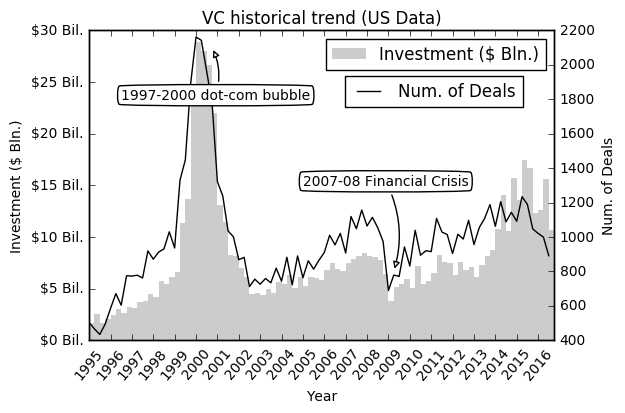

In [17]:
import matplotlib.pyplot  as plt  # http://matplotlib.org/
import matplotlib.patches as mpatches
import matplotlib.ticker  as ticker
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.set_title("VC historical trend (US Data)")
t = range(len(result.index))      # need to substitute tickers for years later
width = t[1]-t[0]
y1 = result['Invested ($ Bill)']

# create filled step chart for investment amount
ax1.bar(t, y1, width=width, facecolor='0.80', edgecolor='', label = 'Investment ($ Bln.)')
ax1.set_ylabel('Investment ($ Bln.)')

# set up xlabels with years
years = [str(year)[:-2] for year in result.index][::4]  # get years without quarter 
ax1.set_xticks(t[::4])                   # set 1 tick per year
ax1.set_xticklabels(years, rotation=50)  # set tick names
ax1.set_xlabel('Year')                   # name X axis

# format Y1 tickers to $ billions
formatter = ticker.FormatStrFormatter('$%1.0f Bil.')
ax1.yaxis.set_major_formatter(formatter)
for tick in ax1.yaxis.get_major_ticks():
    tick.label1On = False
    tick.label2On = True

# create second Y2 axis for Num of Deals
ax2 = ax1.twinx()
y2 = result['Deals']
ax2.plot(t, y2, color = 'k', ls = '-', label = 'Num. of Deals')
ax2.set_ylabel('Num. of Deals')

# add annotation bubbles
ax2.annotate('1997-2000 dot-com bubble', xy=(23, 2100), xytext=(6, 1800),
                bbox=dict(boxstyle="round4", fc="w"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=0.2",
                                fc="w"),
            )

ax2.annotate('2007-08 Financial Crisis', xy=(57, 800), xytext=(40, 1300),
                bbox=dict(boxstyle="round4", fc="w"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="w"), 
            )


# add legend
ax1.legend(loc="best")
ax2.legend(bbox_to_anchor=(0.95, 0.88))

plt.show()

fig.tight_layout()  # solves cropping problems when saving png
fig.savefig('vc_trend.png', dpi=250)